### 1. Importação das bibliotecas

In [1]:
import requests
import pandas as pd
import sqlite3
from plyer import notification
from datetime import datetime
import os

### 2. Função de criação do alerta

In [2]:
def enviar_alerta(nivel, base, etapa):
    if nivel == 1:
        alerta = 'Baixo'
    elif nivel == 2:
        alerta = 'Médio'
    else:
        alerta = 'Alto'

    titulo = f"Alerta {alerta}"
    mensagem = f"Falha no carregamento da base {base} na etapa {etapa} \n{datetime.now()}"
    notification.notify(
        title=titulo,
        message=mensagem,
        app_name="etl_pipeline",
        timeout=10
    )

### 3. Obtendo dados da API

In [3]:
def obter_dados_da_api(url):
    resposta = requests.get(url)
    if resposta.status_code == 200:
        return resposta.json()
    else:
        enviar_alerta(3, url, "Extração")
        print(f"ERRO: Falha ao buscar dados da API. Código de status: {resposta.status_code}")
        return None

### 4. Extração todas as páginas de uma API paginada

In [4]:
def extrair_todas_paginas(base_url):
    resultados = []
    url = base_url
    while url:
        dados = obter_dados_da_api(url)
        if dados:
            resultados.extend(dados['results'])
            url = dados.get('next')
        else:
            break
    return resultados

### 5. Extração dos dados de pokemons

In [5]:
def extrair_pokemons(limite=50):
    url = f'https://pokeapi.co/api/v2/pokemon?limit={limite}'
    dados = obter_dados_da_api(url)
    pokemons = []
    
    for item in dados['results']:
        dados_pokemon = obter_dados_da_api(item['url'])
        if dados_pokemon:
            habilidades = [int(habilidade['ability']['url'].split('/')[-2]) for habilidade in dados_pokemon['abilities']]
            tipos = [int(tipo['type']['url'].split('/')[-2]) for tipo in dados_pokemon['types']]
            pokemons.append({
                'id': dados_pokemon['id'],
                'nome': dados_pokemon['name'],
                'experiencia_base': dados_pokemon['base_experience'],
                'altura': dados_pokemon['height'],
                'peso': dados_pokemon['weight'],
                'id_habilidade_1': habilidades[0] if len(habilidades) > 0 else None,
                'id_habilidade_2': habilidades[1] if len(habilidades) > 1 else None,
                'id_tipo_1': tipos[0] if len(tipos) > 0 else None,
                'id_tipo_2': tipos[1] if len(tipos) > 1 else None
            })
    
    # Converte as colunas id_tipo_1 e id_tipo_2 para INT, garantindo que None seja tratado como NaN e depois convertendo para None
    pokemon_df = pd.DataFrame(pokemons)
    pokemon_df['id_tipo_1'] = pokemon_df['id_tipo_1'].astype('Int64')
    pokemon_df['id_tipo_2'] = pokemon_df['id_tipo_2'].astype('Int64')
    
    return pokemon_df

### 6. Extração dos dados de habilidades

In [6]:
def extrair_habilidades():
    url = 'https://pokeapi.co/api/v2/ability?limit=1000'
    dados = obter_dados_da_api(url)
    habilidades = []
    
    for item in dados['results']:
        dados_habilidade = obter_dados_da_api(item['url'])
        if dados_habilidade:
            habilidades.append({
                'id': dados_habilidade['id'],
                'nome': dados_habilidade['name'],
                'efeito': dados_habilidade['effect_entries'][0]['effect'] if dados_habilidade['effect_entries'] else None
            })
    
    return pd.DataFrame(habilidades)

### 7. Extração dos dados de tipos

In [7]:
def extrair_tipos():
    url = 'https://pokeapi.co/api/v2/type'
    dados = obter_dados_da_api(url)
    tipos = []
    
    for item in dados['results']:
        dados_tipo = obter_dados_da_api(item['url'])
        if dados_tipo:
            tipos.append({
                'id': dados_tipo['id'],
                'nome': dados_tipo['name']
            })
    
    return pd.DataFrame(tipos)

### 8. Função para criar (CREATE) e popular (INSERT INTO) o banco de dados

In [8]:
def criar_e_popular_bd(pokemon_df, habilidades_df, tipos_df, db_name='../pokeapi.db'):
    # Remover banco de dados existente, se houver
    if os.path.exists(db_name):
        os.remove(db_name)
    
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    # Criar tabelas
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS pokemons (
        id INTEGER PRIMARY KEY,
        nome TEXT,
        experiencia_base INTEGER,
        altura INTEGER,
        peso INTEGER,
        id_habilidade_1 INTEGER,
        id_habilidade_2 INTEGER,
        id_tipo_1 INTEGER,
        id_tipo_2 INTEGER,
        FOREIGN KEY (id_habilidade_1) REFERENCES habilidades(id),
        FOREIGN KEY (id_habilidade_2) REFERENCES habilidades(id),
        FOREIGN KEY (id_tipo_1) REFERENCES tipos(id),
        FOREIGN KEY (id_tipo_2) REFERENCES tipos(id)
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS habilidades (
        id INTEGER PRIMARY KEY,
        nome TEXT,
        efeito TEXT
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS tipos (
        id INTEGER PRIMARY KEY,
        nome TEXT
    )
    ''')
    
    # Inserir dados nas tabelas
    pokemon_df.to_sql('pokemons', conn, if_exists='append', index=False)
    habilidades_df.to_sql('habilidades', conn, if_exists='append', index=False)
    tipos_df.to_sql('tipos', conn, if_exists='append', index=False)
    
    conn.commit()
    conn.close()

### 9. Executando o ETL

In [9]:
try:
    pokemons_df = extrair_pokemons(1302)
    habilidades_df = extrair_habilidades()
    tipos_df = extrair_tipos()
    
    criar_e_popular_bd(pokemons_df, habilidades_df, tipos_df)
    print("Dados extraídos e carregados no banco de dados com sucesso!")
except Exception as e:
    enviar_alerta(3, "Processo ETL", "Geral")
    print(f"Erro no processo ETL: {e}")

Dados extraídos e carregados no banco de dados com sucesso!


### 10. Exemplo de erro na extração da base

In [10]:
obter_dados_da_api("https://pokeapi.co/api/v2/pokemon/1/v2")

ERRO: Falha ao buscar dados da API. Código de status: 404


### 11. Função para executar uma consulta e retornar um DataFrame

In [11]:
def executar_consulta(query, db_name='../pokeapi.db'):
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

### 12. Visualizando as tabelas

#### 12.1. Pokémons

In [12]:
query_pokemons = "SELECT * FROM pokemons LIMIT 10"
df_pokemons = executar_consulta(query_pokemons)
df_pokemons

,id,nome,experiencia_base,altura,peso,id_habilidade_1,id_habilidade_2,id_tipo_1,id_tipo_2
0,1,bulbasaur,64,7,69,65,34,12,4.0
1,2,ivysaur,142,10,130,65,34,12,4.0
2,3,venusaur,263,20,1000,65,34,12,4.0
3,4,charmander,62,6,85,66,94,10,NaN
4,5,charmeleon,142,11,190,66,94,10,NaN
5,6,charizard,267,17,905,66,94,10,3.0
6,7,squirtle,63,5,90,67,44,11,NaN
7,8,wartortle,142,10,225,67,44,11,NaN
8,9,blastoise,265,16,855,67,44,11,NaN
9,10,caterpie,39,3,29,19,50,7,NaN


#### 12.2. Habilidades

In [13]:
query_habilidades = "SELECT * FROM habilidades WHERE id IN (19, 34, 44, 50, 65, 66, 67, 94)"
df_habilidades = executar_consulta(query_habilidades)
print(df_habilidades)

   id         nome                                             efeito
0  19  shield-dust  Ein Pokémon mit dieser Fähigkeit ist immun geg...
1  34  chlorophyll  Während strong sunlight ist die speed eines Po...
2  44    rain-dish  Pokémon mit dieser Fähigkeit heilen am Ende je...
3  50     run-away  Pokémon mit dieser Fähigkeit können immer aus ...
4  65     overgrow  When this Pokémon has 1/3 or less of its HP re...
5  66        blaze  Wenn ein Pokémon mit dieser Fähigkeit nur noch...
6  67      torrent  Wenn ein Pokémon mit dieser Fähigkeit nur noch...
7  94  solar-power  Während starkem Sonnenlicht, wird der special ...


#### 12.3. Tipos

In [14]:
query_tipos = "SELECT * FROM tipos WHERE id IN (3.0, 4.0, 7, 10, 11, 12)"
df_tipos = executar_consulta(query_tipos)
print(df_tipos)

   id    nome
0   3  flying
1   4  poison
2   7     bug
3  10    fire
4  11   water
5  12   grass


#### 12.4. Join

In [15]:
query_pokemon_habilidades_tipos = """
SELECT p.nome AS nome, p.experiencia_base AS experiencia_base, h1.nome AS habilidade_1, h2.nome AS habilidade_2, t1.nome AS tipo_1, t2.nome AS tipo_2
FROM pokemons p
LEFT JOIN habilidades h1 ON p.id_habilidade_1 = h1.id
LEFT JOIN habilidades h2 ON p.id_habilidade_2 = h2.id
LEFT JOIN tipos t1 ON p.id_tipo_1 = t1.id
LEFT JOIN tipos t2 ON p.id_tipo_2 = t2.id
ORDER BY p.experiencia_base DESC
LIMIT 10
"""
df_pokemon_habilidades_tipos = executar_consulta(query_pokemon_habilidades_tipos)
df_pokemon_habilidades_tipos

,nome,experiencia_base,habilidade_1,habilidade_2,tipo_1,tipo_2
0,blissey,635,natural-cure,serene-grace,normal,None
1,eternatus-eternamax,563,pressure,None,poison,dragon
2,audino-mega,425,healer,None,normal,fairy
3,chansey,395,natural-cure,serene-grace,normal,None
4,audino,390,healer,regenerator,normal,None
5,zacian-crowned,360,intrepid-sword,None,fairy,steel
6,zamazenta-crowned,360,dauntless-shield,None,fighting,steel
7,zygarde-complete,354,power-construct,None,dragon,ground
8,mewtwo-mega-x,351,steadfast,None,psychic,fighting
9,mewtwo-mega-y,351,insomnia,None,psychic,None


### 13. Hipóteses

In [16]:
# Importando as bibliotecas de visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Retornando consultas com todos os dados das tabelas
query_pokemons = "SELECT * FROM pokemons"
df_pokemons = executar_consulta(query_pokemons)

query_habilidades = "SELECT * FROM habilidades"
df_habilidades = executar_consulta(query_habilidades)

query_tipos = "SELECT * FROM tipos"
df_tipos = executar_consulta(query_tipos)

#### 13.1. Alguns tipos de Pokémons tendem a ter uma experiência base mais alta do que outros

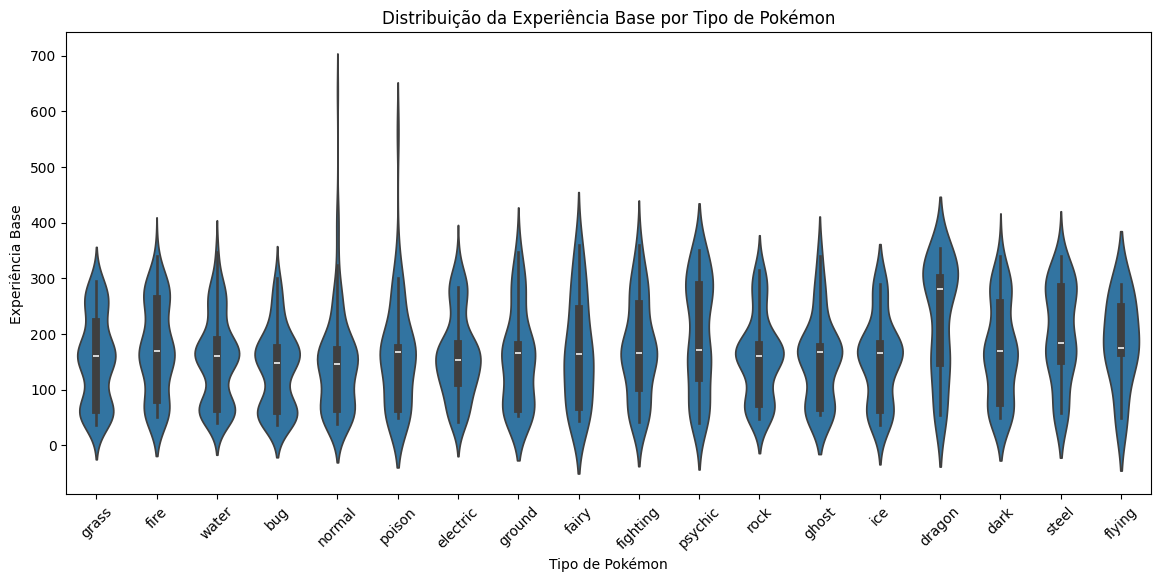

In [18]:
# Juntando dados de pokemons e tipos
df_pokemons_tipos = df_pokemons.merge(df_tipos, left_on='id_tipo_1', right_on='id', suffixes=('_pokemon', '_tipo'))

# Plotando o gráfico violin
plt.figure(figsize=(14, 6))
sns.violinplot(data=df_pokemons_tipos, x='nome_tipo', y='experiencia_base')
plt.title('Distribuição da Experiência Base por Tipo de Pokémon')
plt.xlabel('Tipo de Pokémon')
plt.ylabel('Experiência Base')
plt.xticks(rotation=45)
plt.show()

#### 13.2. A altura e o peso dos Pokémons variam significativamente entre diferentes tipos

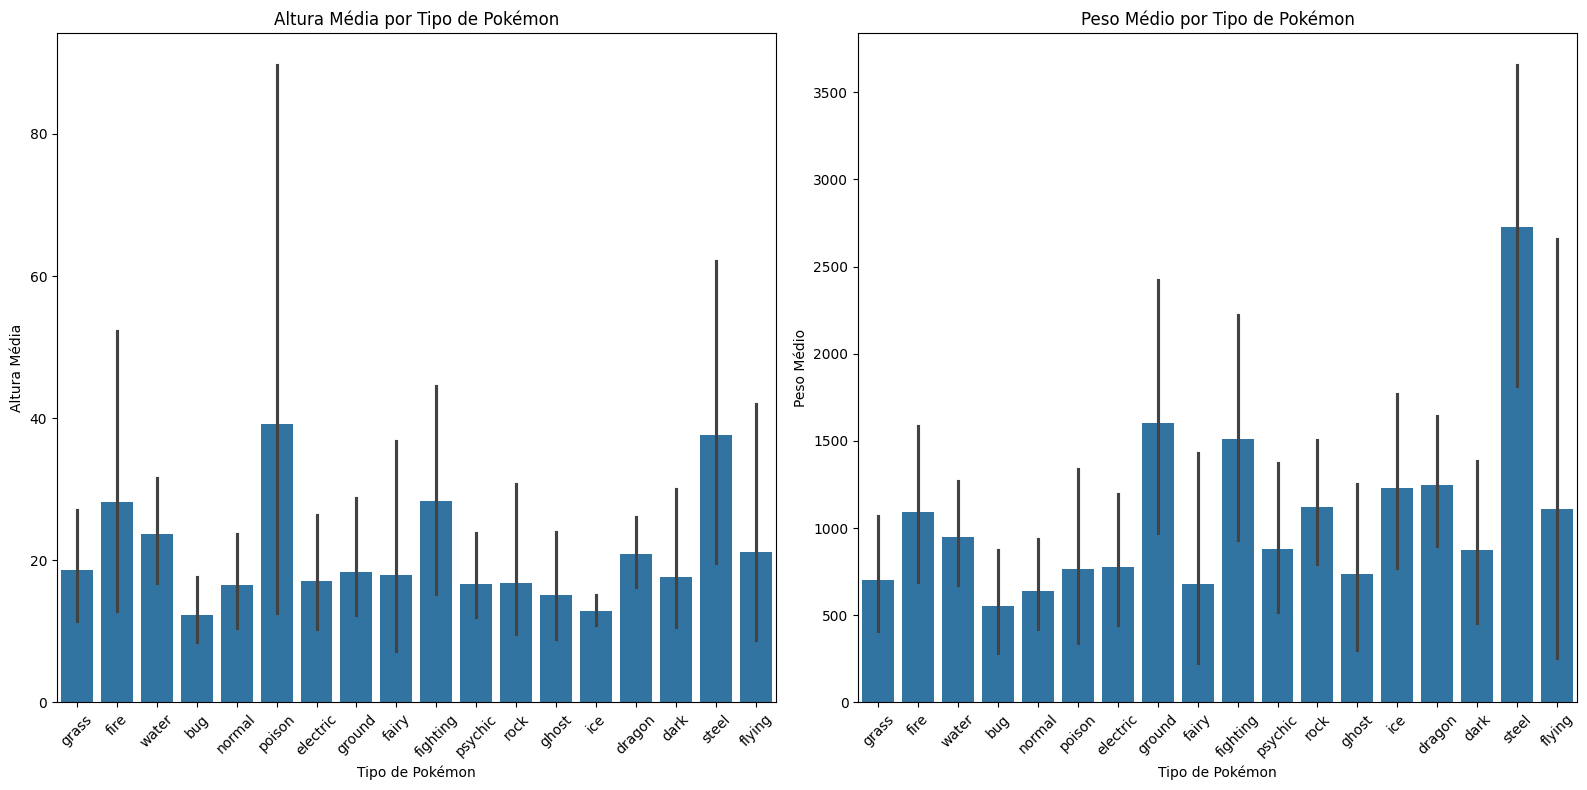

In [19]:
# Criar uma figura com duas subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico de Altura Média por Tipo de Pokémon
sns.barplot(ax=axes[0], data=df_pokemons_tipos, x='nome_tipo', y='altura')
axes[0].set_title('Altura Média por Tipo de Pokémon')
axes[0].set_xlabel('Tipo de Pokémon')
axes[0].set_ylabel('Altura Média')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de Peso Médio por Tipo de Pokémon
sns.barplot(ax=axes[1], data=df_pokemons_tipos, x='nome_tipo', y='peso')
axes[1].set_title('Peso Médio por Tipo de Pokémon')
axes[1].set_xlabel('Tipo de Pokémon')
axes[1].set_ylabel('Peso Médio')
axes[1].tick_params(axis='x', rotation=45)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar a figura com os gráficos
plt.show()

In [20]:
# Consulta SQL para trazer a média da altura e a média do peso por tipo de Pokémon
query_media_altura_peso_por_tipo = """
SELECT 
    t.nome AS tipo,
    AVG(p.altura) AS altura_media,
    AVG(p.peso) AS peso_medio
FROM pokemons p
JOIN tipos t ON p.id_tipo_1 = t.id
GROUP BY t.nome
"""

# Executar a consulta
df_media_altura_peso = executar_consulta(query_media_altura_peso_por_tipo)

# Mostrar os resultados
print(df_media_altura_peso)

        tipo  altura_media   peso_medio
0        bug     12.322581   551.000000
1       dark     17.644068   872.542373
2     dragon     20.865385  1246.442308
3   electric     17.093750   778.322917
4      fairy     17.878788   677.666667
5   fighting     28.298246  1513.157895
6       fire     28.225000  1091.912500
7     flying     21.230769  1112.076923
8      ghost     15.117647   735.215686
9      grass     18.635593   702.500000
10    ground     18.416667  1604.125000
11       ice     12.813953  1229.767442
12    normal     16.492754   641.659420
13    poison     39.196078   767.529412
14   psychic     16.662651   878.638554
15      rock     16.827160  1119.654321
16     steel     37.612245  2727.122449
17     water     23.757962   950.280255
